# 요구사항 1. titanic_dataset.ipynb 분석

In [1]:
import os
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split

In [36]:
class TitanicDataset(Dataset):       
  def __init__(self, X, y):          #x는 입력 데이터, y는 목표값
    self.X = torch.FloatTensor(X)    # 입력 데이터를 floattensor로 변환하여 저장
    self.y = torch.LongTensor(y)     # 목표값을 longtensor로 변환하여 저장

  def __len__(self):                 # dataset 길이(샘플 수)반환
    return len(self.X)

  def __getitem__(self, idx):        # idx에 해당하는 데이터 샘플 반환 (dic 형태 반환)
    feature = self.X[idx]           
    target = self.y[idx]             
    return {'input': feature, 'target': target}

  def __str__(self):                 # dataset 문자열 표현 반환
    str = "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(
      len(self.X), self.X.shape, self.y.shape
    )
    return str

In [37]:
class TitanicTestDataset(Dataset):   
  def __init__(self, X):             # dataset 객체 생성
    self.X = torch.FloatTensor(X)    # 입력 데이터를 floattensor로 변환하여 저장

  def __len__(self):                 # dataset 길이(샘플 수)반환
    return len(self.X)

  def __getitem__(self, idx):        # idx에 해당하는 데이터 샘플 반환 (dic 형태 반환)
    feature = self.X[idx]
    return {'input': feature}

  def __str__(self):                 # dataset 문자열 표현 반환
    str = "Data Size: {0}, Input Shape: {1}".format(
      len(self.X), self.X.shape
    )
    return str

In [38]:
def get_preprocessed_dataset():     #전처리 및 dataset 생성
    CURRENT_FILE_PATH = os.path.dirname(os.path.abspath("__file__"))

    # CSV 파일 : 데이터를 텍스트 파일 형식으로 저장하는 방법 (표 형식의 데이터 저장하기 위해 사용됨)
    train_data_path = os.path.join(CURRENT_FILE_PATH, "train.csv")
    test_data_path = os.path.join(CURRENT_FILE_PATH, "test.csv")

    # CSV 파일을 데이터 조작을 위해 pandas dataframe으로 읽어옴 (data 전처리 및 분석 작업 첫단계)
    train_df = pd.read_csv(train_data_path)
    test_df = pd.read_csv(test_data_path)

    # 분리되어 있는 train 데이터와 test 데이터를 합쳐줌
    all_df = pd.concat([train_df, test_df], sort=False)

     # 데이터 전처리 함수를 1-6까지 차례대로 적용
    all_df = get_preprocessed_dataset_1(all_df)

    all_df = get_preprocessed_dataset_2(all_df)

    all_df = get_preprocessed_dataset_3(all_df)

    all_df = get_preprocessed_dataset_4(all_df)

    all_df = get_preprocessed_dataset_5(all_df)

    all_df = get_preprocessed_dataset_6(all_df)

    # df에서 surivived 열 제거해서 훈련
    train_X = all_df[~all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
    train_y = train_df["Survived"]

    # 테스트 dataset 생성
    test_X = all_df[all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)

    # 훈련 dataset 생성
    dataset = TitanicDataset(train_X.values, train_y.values)
    #print(dataset)
    
    # 학습 dataset을 훈련 & 검증 dataset으로 분할 (무작위로 8:2로 나눔)
    train_dataset, validation_dataset = random_split(dataset, [0.8, 0.2])
    test_dataset = TitanicTestDataset(test_X.values)
    #print(test_dataset)

    return train_dataset, validation_dataset, test_dataset

In [39]:
# all_df 에 대한 전처리 작업 수행 1
def get_preprocessed_dataset_1(all_df):
    
    # Pclass별 Fare 평균값을 사용하여 Fare(요금) 결측치 메우기
    Fare_mean = all_df[["Pclass", "Fare"]].groupby("Pclass").mean().reset_index()
    Fare_mean.columns = ["Pclass", "Fare_mean"]

    # all_df와 fare_mean을 pclass 열을 기준으로 병합
    all_df = pd.merge(all_df, Fare_mean, on="Pclass", how="left")
    # fare열의 결픅치를 fare_mean 값으로 채워줌
    all_df.loc[(all_df["Fare"].isnull()), "Fare"] = all_df["Fare_mean"]

    return all_df

In [40]:
# all_df 에 대한 전처리 작업 수행 
def get_preprocessed_dataset_2(all_df):
    
    # name을 세 개의 컬럼으로 분리하여 다시 all_df에 합침
    name_df = all_df["Name"].str.split("[,.]", n=2, expand=True)
    name_df.columns = ["family_name", "honorific", "name"]

    # 분리된 컬럼 양 끝의 공백 제거
    name_df["family_name"] = name_df["family_name"].str.strip()
    name_df["honorific"] = name_df["honorific"].str.strip()
    name_df["name"] = name_df["name"].str.strip()
    all_df = pd.concat([all_df, name_df], axis=1)

    return all_df

In [41]:
# all_df 에 대한 전처리 작업 수행 3
def get_preprocessed_dataset_3(all_df):
    # honorific별 Age 평균값을 사용하여 Age 결측치 메우기

    # honorific 별로 age의 중앙값 계산하여 honorfic_age_mean dataframe에 저장
    honorific_age_mean = all_df[["honorific", "Age"]].groupby("honorific").median().round().reset_index()
    honorific_age_mean.columns = ["honorific", "honorific_age_mean", ]
   
    #all_df와 honorfic_age_mean을 honorfic 열을 기준으로 병합하여 age열의 null 값을 honorfic_age_mean 값으로 채워줌
    all_df = pd.merge(all_df, honorific_age_mean, on="honorific", how="left")
    all_df.loc[(all_df["Age"].isnull()), "Age"] = all_df["honorific_age_mean"]
    all_df = all_df.drop(["honorific_age_mean"], axis=1)

    return all_df


In [42]:
# all_df 에 대한 전처리 작업 수행 4
def get_preprocessed_dataset_4(all_df):
    # 가족수(family_num) 컬럼 새롭게 추가
    all_df["family_num"] = all_df["Parch"] + all_df["SibSp"]

    # 혼자탑승(alone) 컬럼 새롭게 추가
    all_df.loc[all_df["family_num"] == 0, "alone"] = 1
    all_df["alone"].fillna(0, inplace=True)

    # 학습에 불필요한 컬럼 제거
    all_df = all_df.drop(["PassengerId", "Name", "family_name", "name", "Ticket", "Cabin"], axis=1)

    return all_df


In [43]:
# all_df 에 대한 전처리 작업 수행 5
def get_preprocessed_dataset_5(all_df):
    # honorific 값 개수 줄이기

    # mr, miss, mrs, master 이외의 honorific 값을 가지는 경우, other로 변경
    all_df.loc[
    ~(
            (all_df["honorific"] == "Mr") |
            (all_df["honorific"] == "Miss") |
            (all_df["honorific"] == "Mrs") |
            (all_df["honorific"] == "Master")
    ),
    "honorific"
    ] = "other"
    all_df["Embarked"].fillna("missing", inplace=True)

    return all_df

In [44]:
# all_df 에 대한 전처리 작업 수행 6
def get_preprocessed_dataset_6(all_df):
    # 카테고리 변수를 LabelEncoder를 사용하여 수치값으로 변경하기
    category_features = all_df.columns[all_df.dtypes == "object"]

    # scikit-learn의 LabelEncoder를 사용하여 카테고리 변수를 수치값으로 변환
    from sklearn.preprocessing import LabelEncoder
    for category_feature in category_features:
        le = LabelEncoder()
        if all_df[category_feature].dtypes == "object":
          le = le.fit(all_df[category_feature])
          all_df[category_feature] = le.transform(all_df[category_feature])

    return all_df


In [45]:
from torch import nn

class MyModel(nn.Module):                     # 신경망 모델 정의
  def __init__(self, n_input, n_output):
    super().__init__()

    self.model = nn.Sequential(               # nn.Sequential 사용해여 연속된 레이어 정의
      nn.Linear(n_input, 30),                 # 입력 차원에서 30개의 뉴런으로 연결되는 층
      nn.ReLU(),                              # ReLU : 입력값이 음수면 0, 양수면 그 값 반환하는 활성화 함수
      nn.Linear(30, 30),                      # 30개의 뉴런에서 30개의 뉴런으로 연결되는 층
      nn.ReLU(),
      nn.Linear(30, n_output),                # 30개의 뉴런에서 출력 차원으로 연결되는 층
    )

  def forward(self, x):                      
    x = self.model(x)
    return x

In [46]:
# test 함수 정의 (데스트 데이터를 이용해 모델의 예측을 생성하고 결과 출력)
def test(test_data_loader):
  id = []
  survived = []
  print("[TEST]")
  batch = next(iter(test_data_loader))                      # test_data_loader에서 첫번째 batch 가져옴
  print("{0}".format(batch['input'].shape))                 # 배치의 입력 data 모양 출력
    
  my_model = MyModel(n_input=11, n_output=2)                # 모델 객체 생성
  output_batch = my_model(batch['input'])                   # 입력 데이터에 대한 예측 생성
  prediction_batch = torch.argmax(output_batch, dim=1)      # 예측값 중 최댓값 가지는 라벨 선택

  # 예측 결과 수행
  for idx, prediction in enumerate(prediction_batch, start=892):
      print(idx, prediction.item())
      id.append(idx)
      survived.append(prediction.item())
  return id, survived

In [47]:
if __name__ == "__main__":
    
  # 데이터 전처리 후, 각각 훈련, 검증, 테스트 데이터셋으로 분할
  train_dataset, validation_dataset, test_dataset = get_preprocessed_dataset()

  print("train_dataset: {0}, validation_dataset.shape: {1}, test_dataset: {2}".format(
    len(train_dataset), len(validation_dataset), len(test_dataset)
  ))
  print("#" * 50, 1)

  # 학습 데이터셋의 샘플 출력
  for idx, sample in enumerate(train_dataset):
    print("{0} - {1}: {2}".format(idx, sample['input'], sample['target']))

  print("#" * 50, 2)
    
  # 데이터로더 생성
  train_data_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
  validation_data_loader = DataLoader(dataset=validation_dataset, batch_size=16, shuffle=True)
  test_data_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))
    
  # 학습 데이터로더와 검증 데이터로더의 배치 정보 출력
  print("[TRAIN]")
  for idx, batch in enumerate(train_data_loader):
    print("{0} - {1}: {2}".format(idx, batch['input'].shape, batch['target'].shape))
      
  # 검증 데이터로더의 배치 정보 출력
  print("[VALIDATION]")
  for idx, batch in enumerate(validation_data_loader):
    print("{0} - {1}: {2}".format(idx, batch['input'].shape, batch['target'].shape))

  print("#" * 50, 3)

  test(test_data_loader)

C:\Users\wwsgb\AppData\Local\Temp\ipykernel_16160\1492203356.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_df["alone"].fillna(0, inplace=True)
C:\Users\wwsgb\AppData\Local\Temp\ipykernel_16160\3803746974.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, wh

train_dataset: 713, validation_dataset.shape: 178, test_dataset: 418
################################################## 1
0 - tensor([ 1.0000,  0.0000, 33.0000,  1.0000,  0.0000, 53.1000,  2.0000, 87.5090,
         3.0000,  1.0000,  0.0000]): 1
1 - tensor([ 3.0000,  0.0000, 36.0000,  1.0000,  0.0000, 16.1000,  2.0000, 13.3029,
         3.0000,  1.0000,  0.0000]): 1
2 - tensor([ 3.0000,  1.0000, 23.0000,  0.0000,  0.0000,  7.8542,  2.0000, 13.3029,
         2.0000,  0.0000,  1.0000]): 0
3 - tensor([ 2.0000,  0.0000, 27.0000,  1.0000,  0.0000, 13.8583,  0.0000, 21.1792,
         1.0000,  1.0000,  0.0000]): 1
4 - tensor([  1.0000,   1.0000,  27.0000,   0.0000,   2.0000, 211.5000,   0.0000,
         87.5090,   2.0000,   2.0000,   0.0000]): 0
5 - tensor([  1.0000,   0.0000,  35.0000,   0.0000,   0.0000, 135.6333,   2.0000,
         87.5090,   1.0000,   0.0000,   1.0000]): 1
6 - tensor([ 2.0000,  1.0000, 29.0000,  0.0000,  0.0000,  0.0000,  2.0000, 21.1792,
         2.0000,  0.0000,  1.0000]

# 요구사항 2: titanic 딥러닝 모델 훈련 코드 및 Activation Function 변경하기

In [64]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datetime import datetime
import wandb
import argparse

In [65]:
from pathlib import Path
BASE_PATH = str(Path("__file__").resolve().parent.parent.parent)
print(BASE_PATH, "!!!!!!!")

import sys
sys.path.append(BASE_PATH)

C:\Users\wwsgb\git\link_dl !!!!!!!


In [72]:
# Titanic 데이터셋 로드 및 전처리 함수 임포트
from titanic_dataset import get_preprocessed_dataset, TitanicDataset, TitanicTestDataset

# 1. 데이터 로딩 함수 정의 (기존 전처리 사용)
def get_data():
    # 이미 정의된 get_preprocessed_dataset 함수를 사용합니다.
    train_dataset, validation_dataset, test_dataset = get_preprocessed_dataset()

    # DataLoader 생성
    train_data_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
    validation_data_loader = DataLoader(dataset=validation_dataset, batch_size=len(validation_dataset))
    test_data_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))

    return train_data_loader, validation_data_loader, test_data_loader

In [89]:
# 2. 모델 정의
class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_input, wandb.config.n_hidden_unit_list[0]),
            nn.PReLU(),
            nn.Dropout(0.2),
            nn.Linear(wandb.config.n_hidden_unit_list[0], wandb.config.n_hidden_unit_list[1]),
            nn.PReLU(),
            nn.Dropout(0.2),
            nn.Linear(wandb.config.n_hidden_unit_list[1], n_output)
        )

    def forward(self, x):
        return self.model(x)

In [90]:
# 3. 모델과 옵티마이저 생성
def get_model_and_optimizer():
    my_model = MyModel(n_input=11, n_output=2)  # Titanic 데이터셋에 맞게 설정
    optimizer = optim.SGD(my_model.parameters(), lr=wandb.config.learning_rate)
    return my_model, optimizer

In [91]:
# 4. 학습 루프 정의
def training_loop(model, optimizer, train_data_loader, validation_data_loader):
    n_epochs = wandb.config.epochs
    loss_fn = nn.BCEWithLogitsLoss()
    next_print_epoch = 100
    loss_list = []
    count = 0

    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        num_trains = 0

        # Training Loop
        for batch in train_data_loader:
            input_data = batch['input']
            target = torch.cat((1 - batch['target'].unsqueeze(1), batch['target'].unsqueeze(1)), dim=1).float()
            output_train = model(input_data)
            loss = loss_fn(output_train, target)

            loss_train += loss.item()
            num_trains += 1

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation Loop
        loss_validation = 0.0
        num_validations = 0
        with torch.no_grad():
            for batch in validation_data_loader:
                input_data = batch['input']
                target = torch.cat((1 - batch['target'].unsqueeze(1), batch['target'].unsqueeze(1)), dim=1).float()
                output_validation = model(input_data)
                loss = loss_fn(output_validation, target)

                loss_validation += loss.item()
                num_validations += 1

        wandb.log({
            "Epoch": epoch,
            "Training loss": loss_train / num_trains,
            "Validation loss": loss_validation / num_validations
        })

        if epoch >= next_print_epoch:
            print(
                f"Epoch {epoch}, "
                f"Training loss {loss_train / num_trains:.4f}, "
                f"Validation loss {loss_validation / num_validations:.4f}"
            )
            next_print_epoch += 100


In [92]:
# test 함수 정의 (데스트 데이터를 이용해 모델의 예측을 생성하고 결과 출력)
def test(test_data_loader):
  id = []
  survived = []
  print("[TEST]")
  batch = next(iter(test_data_loader))                      # test_data_loader에서 첫번째 batch 가져옴
  print("{0}".format(batch['input'].shape))                 # 배치의 입력 data 모양 출력
    
  my_model = MyModel(n_input=11, n_output=2)                # 모델 객체 생성
  output_batch = my_model(batch['input'])                   # 입력 데이터에 대한 예측 생성
  prediction_batch = torch.argmax(output_batch, dim=1)      # 예측값 중 최댓값 가지는 라벨 선택

  # 예측 결과 수행
  for idx, prediction in enumerate(prediction_batch, start=892):
      print(idx, prediction.item())
      id.append(idx)
      survived.append(prediction.item())
  return id, survived

In [93]:
if __name__ == "__main__":

  args = argparse.Namespace(wandb=True, batch_size=16, epochs=3000)
  main(args)

C:\Users\wwsgb\git\link_dl\_02_homeworks\homework_2\titanic_dataset.py:121: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_df["alone"].fillna(0, inplace=True)
C:\Users\wwsgb\git\link_dl\_02_homeworks\homework_2\titanic_dataset.py:140: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

################################################## 1
Epoch 100, Training loss 0.9521, Validation loss 0.9473
Epoch 200, Training loss 0.7932, Validation loss 0.7507
Epoch 300, Training loss 0.7348, Validation loss 0.6803
Epoch 400, Training loss 0.7144, Validation loss 0.6710
Epoch 500, Training loss 0.6681, Validation loss 0.7162
Epoch 600, Training loss 0.6624, Validation loss 0.6804
Epoch 700, Training loss 0.6438, Validation loss 0.6238
Epoch 800, Training loss 0.6464, Validation loss 0.6888
Epoch 900, Training loss 0.6508, Validation loss 0.6701
Epoch 1000, Training loss 0.6371, Validation loss 0.5951
Epoch 1100, Training loss 0.6452, Validation loss 0.6779
Epoch 1200, Training loss 0.6462, Validation loss 0.6557
Epoch 1300, Training loss 0.6435, Validation loss 0.6309
Epoch 1400, Training loss 0.6251, Validation loss 0.6113
Epoch 1500, Training loss 0.6217, Validation loss 0.6427
Epoch 1600, Training loss 0.6303, Validation loss 0.6624
Epoch 1700, Training loss 0.6348, Validation

Epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
Training loss,█▆▃▂▂▂▂▂▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation loss,█▇▆▅▅▃▃▃▃▂▂▁▁▂▂▂▂▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,3000
Training loss,0.60877
Validation loss,0.60728


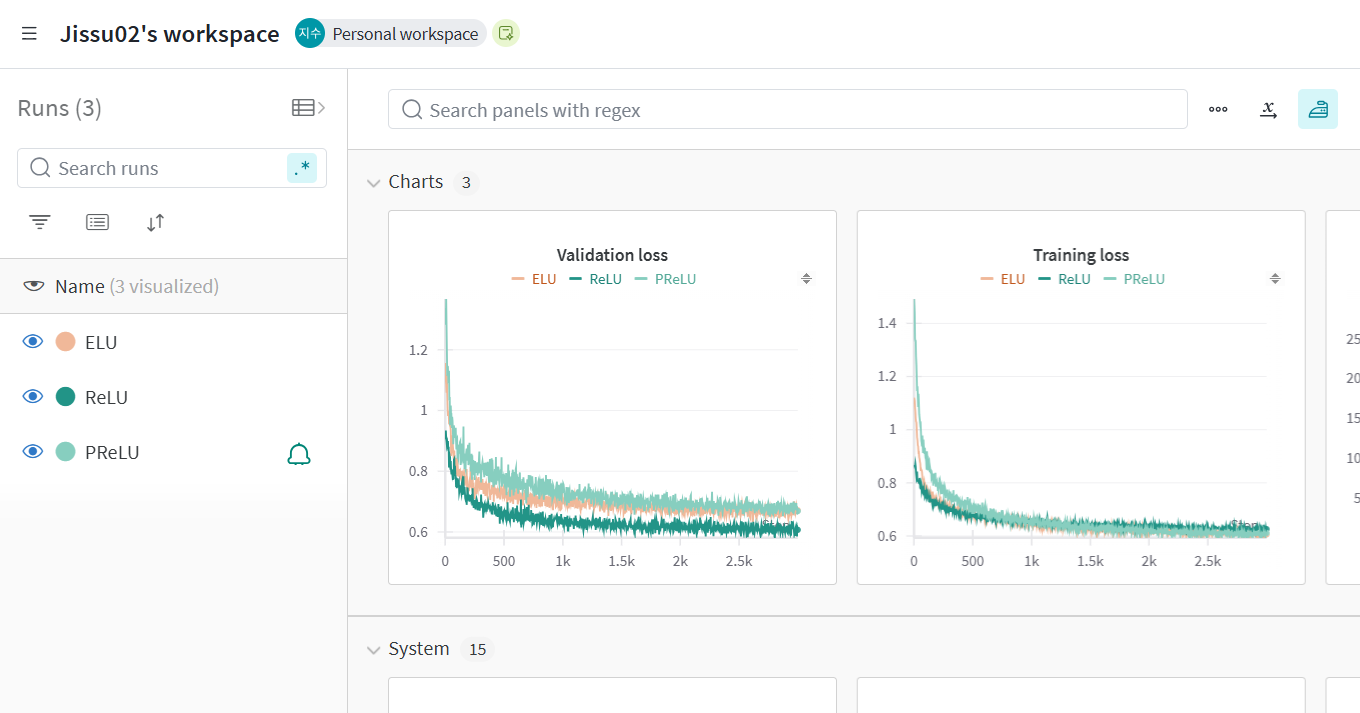

In [94]:
from IPython.display import Image
CURRENT_FILE_PATH = os.path.dirname(os.path.abspath("__file__"))
img = os.path.join(CURRENT_FILE_PATH, "activation.png") # train.csv 파일 경로
Image(img)

PReLu, ELU, ReLU 3개의 모델 구성 중 가장 나은 성능을 보인 PReLU 모델을 선정하였다.

# 요구사항 3. 테스트 및 submission.csv 생성

In [8]:
# test 함수 정의 (데스트 데이터를 이용해 모델의 예측을 생성하고 결과 출력)
def test(test_data_loader):
  id = []
  survived = []
  print("[TEST]")
  batch = next(iter(test_data_loader))                      # test_data_loader에서 첫번째 batch 가져옴
  print("{0}".format(batch['input'].shape))                 # 배치의 입력 data 모양 출력
    
  my_model = MyModel(n_input=11, n_output=2)                # 모델 객체 생성
  output_batch = my_model(batch['input'])                   # 입력 데이터에 대한 예측 생성
  prediction_batch = torch.argmax(output_batch, dim=1)      # 예측값 중 최댓값 가지는 라벨 선택

  # 예측 결과 수행
  for idx, prediction in enumerate(prediction_batch, start=892):
      print(idx, prediction.item())
      id.append(idx)
      survived.append(prediction.item())
  return id, survived

In [ ]:
# submission 파일 생성
  idx, survived = test(test_data_loader)
  data = pd.DataFrame({'PassengerId': idx, 'Survived': survived})
  data.to_csv('C:/Users/wwsgb/git/link_dl/_02_homeworks/homework_2/gender_submission.csv', index=False)

# 요구사항 4. submission.csv 제출 및 등수확인

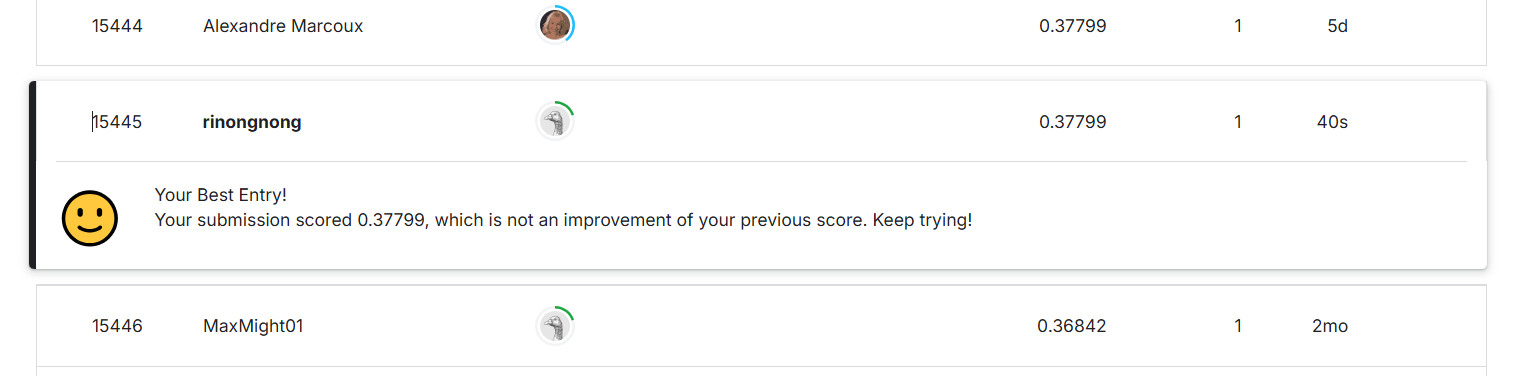

In [3]:
from IPython.display import Image
CURRENT_FILE_PATH = os.path.dirname(os.path.abspath("__file__")) # 현재 디렉토리 경로 가져오기
img = os.path.join(CURRENT_FILE_PATH, "kaggle.png") # train.csv 파일 경로
Image(img)

# <숙제 후기>
캘리포니아 주택 가격 데이터셋과 타이타닉 승객 생존 데이터셋을 비교하면서, 같은 머신러닝 기술이라도 서로 다른 데이터 특성에 따라 접근 방법과 사용해야 할 기법이 달라진다는 점을 알 수 있었다. 타이타닉 데이터셋은 이진 분류 문제로, 생존 여부를 예측하는 것이 목표였다. 이를 위해 BCE 함수를 사용했고, 이는 두 클래스 간의 예측을 명확하게 구분하는 데 매우 효과적이었다. 또한, 여러 활성화 함수를 실험해 본 결과, PReLU가 기존의 ReLU나 ELU에 비해 모델의 학습에 있어 더 나은 결과를 보여주는 것을 알 수 있었다. PReLU의 적응형 기능 덕분에 모델이 더 복잡한 패턴을 학습할 수 있었고, 이는 최종적으로 더 높은 정확도를 보일 수 있었다고 본다.